[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/RGB_SQ/RD_performance.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/RGB_SQ/RD_performance.ipynb)

#  Scalar Quantization of RGB images

In [ ]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/scalar_quantization" ]; then
    cd $HOME/repos/scalar_quantization
    echo "$HOME/repos/scalar_quantization ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/scalar_quantization.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/color_DCT" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/color_DCT ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/color_DCT.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/MRVC" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/MRVC ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/Sistemas-Multimedia/MRVC.git
fi

In [ ]:
!ln -sf ~/repos/information_theory/information.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/scalar_quantization/quantization.py .
!ln -sf ~/repos/scalar_quantization/deadzone_quantization.py .
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/image_3.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [1]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import colored
except:
    !pip install colored
    import colored
    
import pylab
import math
import numpy as np

try:
    from scipy import signal
except:
    !pip install scipy
    from scipy import signal
    
try:
    import cv2
except:
    !pip install opencv-python
    !pip install opencv-python-headless # Binder compatibility

try:
    import skimage
except:
    !pip install scikit-image

try:
    import PIL
except:
    !pip install PIL
    
import os
#import quantization
import deadzone_quantization as deadzone
#import midtread_quantizer as midtread
#import midrise_quantizer as midrise
import color_DCT
import distortion
import information
import image_3 as RGB_image
import image_1 as gray_image

## Configuration

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/repos/MRVC/images/stockholm/"
#fn = home + "/repos/MRVC/images/Hommer/"
#fn = home + "/repos/MRVC/images/fluorescence/"
#fn = home + "/repos/MRVC/images/blue_rose/"
fn = home + "/repos/MRVC/images/lena_color/"
#fn = home + "/repos/MRVC/images/nored_lena/"

components = ['R', 'G', 'B']

#quantizer = midtread
quantizer = deadzone.Deadzone_Quantizer
#quantizer = midrise

Q_steps = [2**i for i in range(7, -1, -1)] # Quantization steps (simulating bit-plane encoding)
print(Q_steps)

#RGB_image.write = RGB_image.debug_write # Faster, but lower compression
RGB_image.write = information.write # The fastest, but returns only an estimation of the length
#gray_image.write = gray_image.debug_write # Faster, but lower compression
gray_image.write = information.write # The fastest, but returns only an estimation of the length

[128, 64, 32, 16, 8, 4, 2, 1]


#entropy_estimator = "PNG"
entropy_estimator = "entropy"
if entropy_estimator == "PNG":
    def compute_BPP(_image, filename_prefix):
        BPP = RGB_image.write(_image, filename_prefix, 0)*8/(_image.shape[0]*_image.shape[1])
        return BPP
else:
    def compute_BPP(_image, filename_prefix=''):
        if len(_image.shape > 2):
            entropy = information.entropy(_image.flatten().astype(np.int16))*_image.shape[2]
        else:
            entropy = information.entropy(_image.flatten().astype(np.int16))
        return entropy

# Run this cell if you want to estimate the BPP using the entropy
class RGB_image(RGB_image):
    def write(image, filename_prefix):
        return information.entropy(image.flatten().astype(np.int16))*image.shape[2]
class gray_image(gray_image):
    def write(image, filename_prefix):
        return information.entropy(image.flatten().astype(np.int16))

## Read the image and show it

In [3]:
RGB_img = RGB_image.read(fn).astype(np.int16) # 8 bits/components is not sufficient to shift the components to [-128, 127]

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1


In [4]:
# Change G and B channels by noise
#RGB_img[...,1] = np.random.normal(loc=0, scale=20, size=512*512).reshape(512, 512) + 128
#RGB_img[...,2] = np.random.normal(loc=0, scale=20, size=512*512).reshape(512, 512) + 128

[image_3.py:84 print_stats() INFO] component=0 max=255 min=54 avg=180.22401428222656
[image_3.py:84 print_stats() INFO] component=1 max=248 min=1 avg=99.05646133422852
[image_3.py:84 print_stats() INFO] component=2 max=239 min=8 avg=105.41263198852539


(512, 512, 3)
int16
255 1


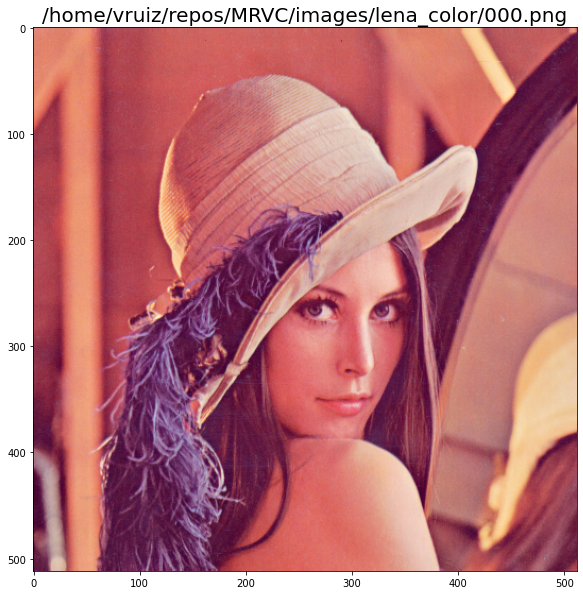

In [5]:
#RGB_img[..., 0] //= 32
#RGB_img[..., 0] *= 32
print(RGB_img.shape)
print(RGB_img.dtype)
print(RGB_img.max(), RGB_img.min())
RGB_image.show(RGB_img, fn + "000.png")

[image_1.py:62 print_stats() INFO] max=255 min=54 avg=180.22401428222656


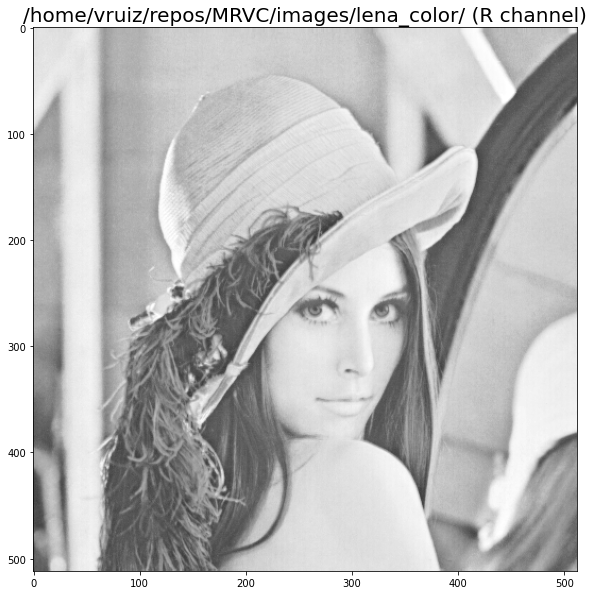

In [6]:
gray_image.show(RGB_img[..., 0], fn + " (R channel)")

[image_1.py:62 print_stats() INFO] max=248 min=1 avg=99.05646133422852


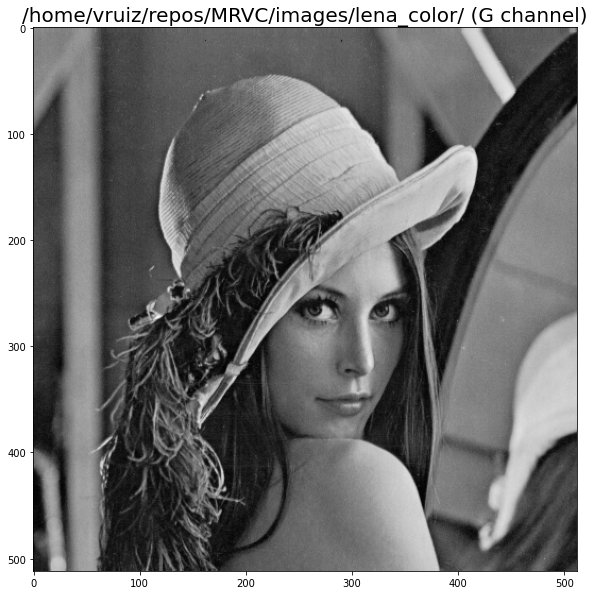

In [7]:
gray_image.show(RGB_img[..., 1], fn + " (G channel)")

[image_1.py:62 print_stats() INFO] max=239 min=8 avg=105.41263198852539


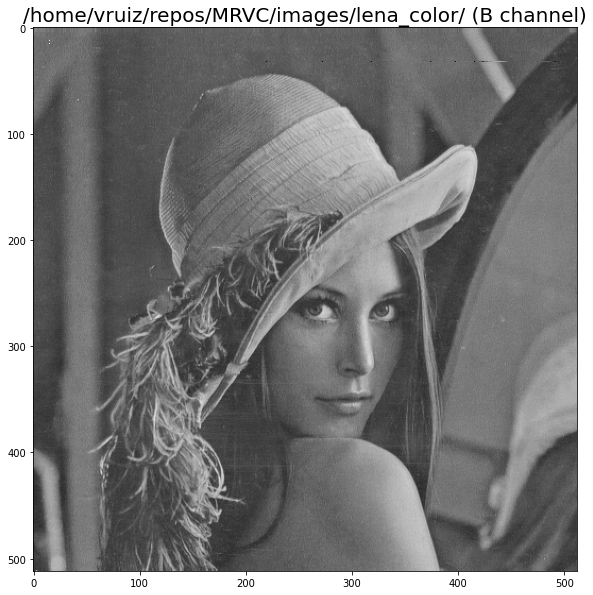

In [8]:
gray_image.show(RGB_img[..., 2], fn + " (B channel)")

## Energy of the RGB components

In [9]:
R_avg_energy = information.average_energy(RGB_img[...,0])
G_avg_energy = information.average_energy(RGB_img[...,1])
B_avg_energy = information.average_energy(RGB_img[...,2])
print(f"Average energy R = {R_avg_energy}")
print(f"Average energy G = {G_avg_energy}")
print(f"Average energy B = {B_avg_energy}")
total_RGB_avg_energy = R_avg_energy + G_avg_energy + B_avg_energy
print(f"Total RGB average energy (computed by adding the energies of the components) = {total_RGB_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(RGB_img)*3}")

Average energy R = 34886.45802307129
Average energy G = 12608.167423248291
Average energy B = 12271.964656829834
Total RGB average energy (computed by adding the energies of the components) = 59766.590103149414
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414


The RGB domain is additive. This basically tell us that the addition of the distortion generated in each component (by lossy compression) equals the distortion measured in the RGB domain (this is a trivial conclusion!!).

## Show some quantizations

/home/vruiz/repos/Sistemas-Multimedia.github.io/contents/RGB_SQ/image_3.py:76: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_component) / max_min_component
[image_3.py:84 print_stats() INFO] component=0 max=0 min=0 avg=0.0
[image_3.py:84 print_stats() INFO] component=1 max=0 min=0 avg=0.0
[image_3.py:84 print_stats() INFO] component=2 max=0 min=0 avg=0.0


Used quantization indexes: [0]


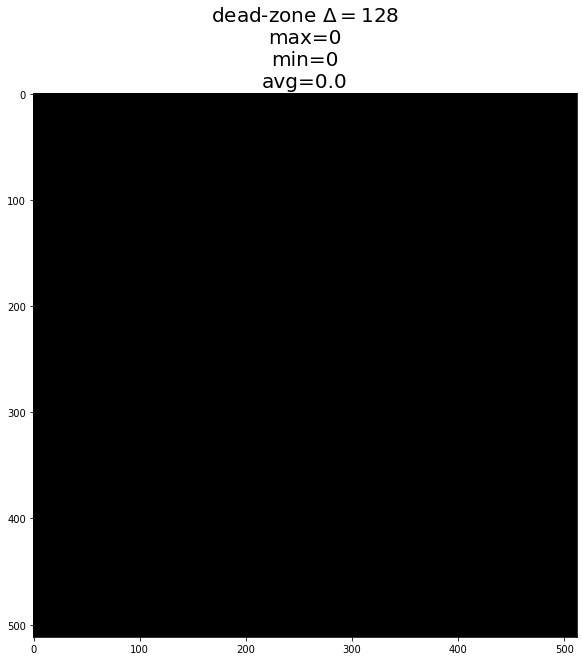

In [10]:
QS = 128 # Quantization Step
_RGB_img = RGB_img.astype(np.int16) - 128 # Quantized data must be centered at 0
Q = quantizer(Q_step=QS)
y, k = Q.quan_dequan(_RGB_img)
print("Used quantization indexes:", np.unique(k))
RGB_image.show_normalized(k, f"{deadzone.name} $\\Delta={QS}$")

[image_3.py:84 print_stats() INFO] component=0 max=1 min=-1 avg=0.5359001159667969
[image_3.py:84 print_stats() INFO] component=1 max=1 min=-1 avg=-0.22278213500976562
[image_3.py:84 print_stats() INFO] component=2 max=1 min=-1 avg=-0.08307266235351562


Used quantization indexes: [-1  0  1]


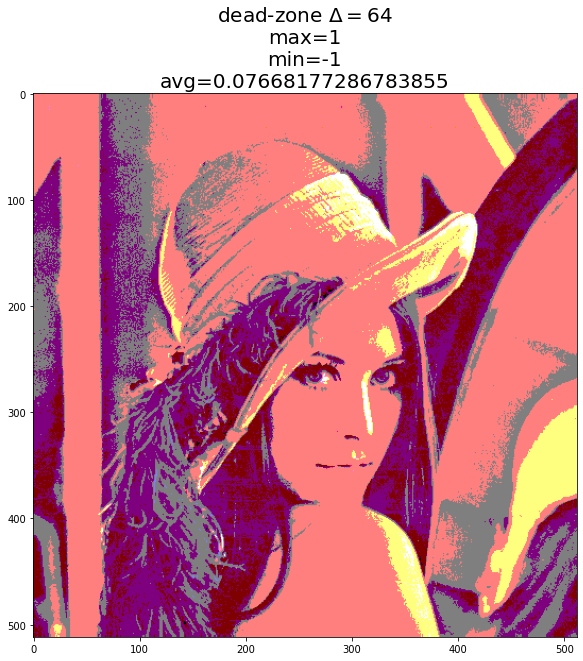

In [11]:
QS = 64 # Quantization Step
_RGB_img = RGB_img.astype(np.int16) - 128 # Quantized data must be centered at 0 if we use deadzone
Q = quantizer(Q_step=QS)
y, k = Q.quan_dequan(_RGB_img)
print("Used quantization indexes:", np.unique(k))
RGB_image.show_normalized(k, f"{deadzone.name} $\\Delta={QS}$")

## RD curve using same quantization step for each RGB channel ($\mathbf\Delta^{\text{R}}_i = \mathbf\Delta^{\text{G}}_i = \mathbf\Delta^{\text{B}}_i$)

[image_3.py:84 print_stats() INFO] component=0 max=255 min=54 avg=180.22401428222656
[image_3.py:84 print_stats() INFO] component=1 max=248 min=1 avg=99.05646133422852
[image_3.py:84 print_stats() INFO] component=2 max=239 min=8 avg=105.41263198852539


['R', 'G', 'B'] [128, 64, 32, 16, 8, 4, 2, 1]
Quantization indexes:  [128]
q_step=128, rate=    0.0 bits/pixel, distortion=  59.0
Quantization indexes:  [127 128 129]
q_step= 64, rate=3.6922466043807 bits/pixel, distortion=  33.7
Quantization indexes:  [125 126 127 128 129 130 131]
q_step= 32, rate=7.5290068916119655 bits/pixel, distortion=  17.1
Quantization indexes:  [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135]
q_step= 16, rate=10.850945957671929 bits/pixel, distortion=   8.7
Quantization indexes:  [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143]
q_step=  8, rate=14.04130579985262 bits/pixel, distortion=   4.1
Quantization indexes:  [ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159]
q_ste

[image_3.py:84 print_stats() INFO] component=0 max=255 min=54 avg=180.22401428222656
[image_3.py:84 print_stats() INFO] component=1 max=248 min=1 avg=99.05646133422852
[image_3.py:84 print_stats() INFO] component=2 max=239 min=8 avg=105.41263198852539


Quantization indexes:  [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191]
q_step=  2, rate=19.734254945179213 bits/pixel, distortion=   1.2
Quantization indexes:  [  1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  

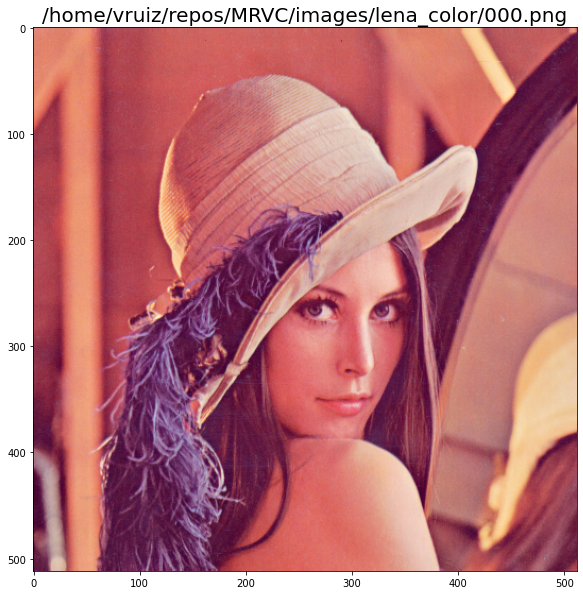

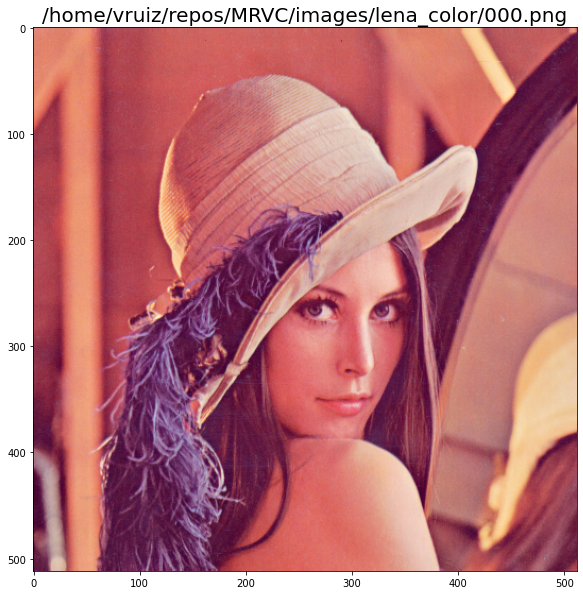

In [12]:
def same_delta_RD_curve(RGB_img, Q_steps, quantizer):
    RGB_img = RGB_img.copy()
    RGB_img -= 128
    points = []
    for Q_step in Q_steps:
        Q = quantizer(Q_step=Q_step)
        y, k = Q.quan_dequan(RGB_img)
        k = (k + 128).astype(np.uint8) # Only positive components can be written in an PNG file
        print("Quantization indexes: ", np.unique(k))
        rate = RGB_image.write(k, "/tmp/" + str(Q_step) + '_', 0)*8/(k.shape[0]*k.shape[1])
        #rate = compute_BPP(k, "/tmp/" + str(Q_step) + '_')
        _distortion = distortion.RMSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

def not__same_delta_RD_curve(RGB_img, Q_steps, quantizer):
    RGB_img = RGB_img.copy()
    RGB_img -= 128
    points = []
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    for Q_step in Q_steps:
        Q = quantizer(Q_step=Q_step*1)
        y[..., 0], k[..., 0] = Q.quan_dequan(RGB_img[..., 0])
        Q = quantizer(Q_step=Q_step*1)
        y[..., 1], k[..., 1] = Q.quan_dequan(RGB_img[..., 1])
        Q = quantizer(Q_step=Q_step*2)
        y[..., 2], k[..., 2] = Q.quan_dequan(RGB_img[..., 2])
        k = (k + 128).astype(np.uint8) # Only positive components can be written in an PNG file
        print("Quantization indexes: ", np.unique(k))
        rate = RGB_image.write(k, "/tmp/" + str(Q_step) + '_', 0)*8/(k.shape[0]*k.shape[1])
        #rate = compute_BPP(k, "/tmp/" + str(Q_step) + '_')
        _distortion = distortion.RMSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RGB_image.show(RGB_img, fn + "000.png")
print(components, Q_steps)
same_delta_RD_points = same_delta_RD_curve(RGB_img, Q_steps, quantizer)
not_same_delta_RD_points = not__same_delta_RD_curve(RGB_img, Q_steps, quantizer)
RGB_image.show(RGB_img, fn + "000.png")

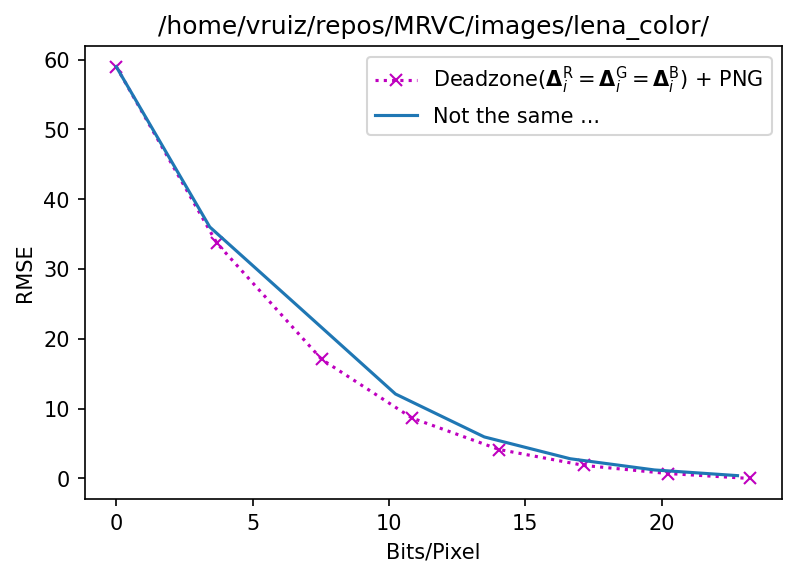

In [36]:
pylab.figure(dpi=150)
pylab.plot(*zip(*same_delta_RD_points), c='m', marker='x', label="Deadzone($\mathbf{\Delta}^{\mathrm{R}}_i=\mathbf{\Delta}^{\mathrm{G}}_i=\mathbf{\Delta}^{\mathrm{B}}_i}$) + PNG", linestyle="dotted")
pylab.plot(*zip(*not_same_delta_RD_points), label="Not the same ...")
pylab.title(fn)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [14]:
def RD_curve_of_channel(RGB_img, Q_steps, component, components, quantizer):
    RGB_img = RGB_img.copy()
    RGB_img -= 128
    RD_points = [(0, 100000, component, 256)]
    #RD_points = []
    component_index = components.index(component)
    for Q_step in Q_steps:
        print(f"q_step={Q_step}")
        Q = quantizer(Q_step=Q_step)
        component_img = RGB_img[..., component_index]
        dequantized_component_img, k = Q.quan_dequan(component_img)
        k = (k + 128).astype(np.uint8)
        BPP = gray_image.write(k, component + str(Q_step) + '_', 0)*8/k.size
        RMSE = distortion.RMSE(component_img, dequantized_component_img)
        # We can measure the distortion in the component's domain because it is additive
        RD_points.append((BPP, RMSE, component, Q_step))
        print(f"Q_step={Q_step:>3}, rate={BPP:>.3f} bits/pixel, distortion={RMSE}")
    return RD_points

def R_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve_of_channel(RGB_img, Q_steps, 'R', components, quantizer)

def G_RD_curve(RGB_img, Q_steps, components, quantizer):
    #return RD_curve_of_channel(RGB_img, [int(1.3*i) for i in Q_steps], 'G', components, quantizer)
    return RD_curve_of_channel(RGB_img, Q_steps, 'G', components, quantizer)

def B_RD_curve(RGB_img, Q_steps, components, quantizer):
    #return RD_curve_of_channel(RGB_img, [int(0.7*i) for i in Q_steps if int(0.9*i)!=0], 'B', components, quantizer)
    return RD_curve_of_channel(RGB_img, Q_steps, 'B', components, quantizer)

In [15]:
print("R component")
R_points = R_RD_curve(RGB_img, Q_steps, components, quantizer)

R component
q_step=128
Q_step=128, rate=0.000 bits/pixel, distortion=71.64572818264386
q_step=64
Q_step= 64, rate=1.000 bits/pixel, distortion=33.75620625264766
q_step=32
Q_step= 32, rate=2.216 bits/pixel, distortion=17.634181884270646
q_step=16
Q_step= 16, rate=3.229 bits/pixel, distortion=8.894503801560633
q_step=8
Q_step=  8, rate=4.241 bits/pixel, distortion=4.175766633510434
q_step=4
Q_step=  4, rate=5.246 bits/pixel, distortion=1.8686701422631917
q_step=2
Q_step=  2, rate=6.251 bits/pixel, distortion=0.7132517278939814
q_step=1
Q_step=  1, rate=7.253 bits/pixel, distortion=0.0


In [16]:
print("G component")
G_points = G_RD_curve(RGB_img, Q_steps, components, quantizer)

G component
q_step=128
Q_step=128, rate=0.000 bits/pixel, distortion=60.28028966159495
q_step=64
Q_step= 64, rate=1.170 bits/pixel, distortion=32.925088704771035
q_step=32
Q_step= 32, rate=2.336 bits/pixel, distortion=16.648477941828226
q_step=16
Q_step= 16, rate=3.435 bits/pixel, distortion=8.590805825571081
q_step=8
Q_step=  8, rate=4.511 bits/pixel, distortion=4.138273672738249
q_step=4
Q_step=  4, rate=5.559 bits/pixel, distortion=1.867972875165353
q_step=2
Q_step=  2, rate=6.585 bits/pixel, distortion=0.7149531379761566
q_step=1
Q_step=  1, rate=7.595 bits/pixel, distortion=0.0


In [17]:
print("Blue component")
B_points = B_RD_curve(RGB_img, Q_steps, components, quantizer)

Blue component
q_step=128
Q_step=128, rate=0.000 bits/pixel, distortion=40.869681522704994
q_step=64
Q_step= 64, rate=0.527 bits/pixel, distortion=34.39817838725016
q_step=32
Q_step= 32, rate=1.737 bits/pixel, distortion=16.923687246961254
q_step=16
Q_step= 16, rate=2.814 bits/pixel, distortion=8.468501126056575
q_step=8
Q_step=  8, rate=3.876 bits/pixel, distortion=4.128179538548467
q_step=4
Q_step=  4, rate=4.926 bits/pixel, distortion=1.8628420522080258
q_step=2
Q_step=  2, rate=5.955 bits/pixel, distortion=0.709850108483243
q_step=1
Q_step=  1, rate=6.969 bits/pixel, distortion=0.0


In [18]:
R_points

[(0, 100000, 'R', 256),
 (0.0, 71.64572818264386, 'R', 128),
 (1.000426976275625, 33.75620625264766, 'R', 64),
 (2.216163697843425, 17.634181884270646, 'R', 32),
 (3.2292514959286343, 8.894503801560633, 'R', 16),
 (4.2406503294692195, 4.175766633510434, 'R', 8),
 (5.245580500934037, 1.8686701422631917, 'R', 4),
 (6.25090807266912, 0.7132517278939814, 'R', 2),
 (7.253084525591924, 0.0, 'R', 1)]

In [19]:
G_points

[(0, 100000, 'G', 256),
 (0.0, 60.28028966159495, 'G', 128),
 (1.1695730178725294, 32.925088704771035, 'G', 64),
 (2.3362866205096373, 16.648477941828226, 'G', 32),
 (3.435012293365204, 8.590805825571081, 'G', 16),
 (4.510658448429974, 4.138273672738249, 'G', 8),
 (5.558895056590706, 1.867972875165353, 'G', 4),
 (6.584547454439178, 0.7149531379761566, 'G', 2),
 (7.595153374790037, 0.0, 'G', 1)]

In [20]:
B_points

[(0, 100000, 'B', 256),
 (0.0, 40.869681522704994, 'B', 128),
 (0.5272303330951359, 34.39817838725016, 'B', 64),
 (1.7373757961555039, 16.923687246961254, 'B', 32),
 (2.8143294439409305, 8.468501126056575, 'B', 16),
 (3.8760713048631055, 4.128179538548467, 'B', 8),
 (4.926085630785907, 1.8628420522080258, 'B', 4),
 (5.9554125532855675, 0.709850108483243, 'B', 2),
 (6.968581625315276, 0.0, 'B', 1)]

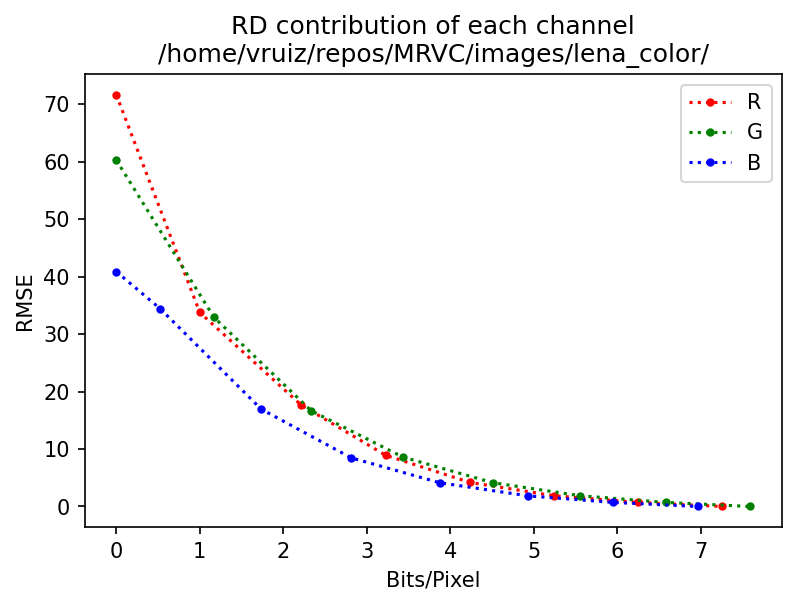

In [23]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*[(i[0], i[1]) for i in R_points]), c='r', marker='.', s=0.5, label='R')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in G_points]), c='g', marker='.', s=0.5, label='G')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in B_points]), c='b', marker='.', s=0.5, label='B')              
pylab.plot(*zip(*[(i[0], i[1]) for i in R_points[1:]]), c='r', marker='.', label=f"R", linestyle="dotted")
pylab.plot(*zip(*[(i[0], i[1]) for i in G_points[1:]]), c='g', marker='.', label=f"G", linestyle="dotted")
pylab.plot(*zip(*[(i[0], i[1]) for i in B_points[1:]]), c='b', marker='.', label=f"B", linestyle="dotted")
#pylab.plot(*zip(*[(i[0], i[1]) for i in R_points_2]), c='r', marker='x', label=f"R ({quantizer_2.name})", linestyle="dotted")              
#pylab.plot(*zip(*[(i[0], i[1]) for i in G_points_2]), c='g', marker='x', label=f"G ({quantizer_2.name})", linestyle="dotted")
#pylab.plot(*zip(*[(i[0], i[1]) for i in B_points_2]), c='b', marker='x', label=f"B ({quantizer_2.name})", linestyle="dotted")
pylab.title(f"RD contribution of each channel\n{fn}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

This graph shows an approximation of the RD curves of the three channels (ideally, the curve is continuous but here we have only plotted 8 points/curve). Notice that if we modify the quantization pattern $\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$, we are modifying where the curves are "sampled", but not the shape or the localization of the curves in the RD space. Ideally, the curves should be sampled satisfiying that $\lambda_{\mathrm{R}}=\lambda_{\mathrm{G}}=\lambda_{\mathrm{B}}$, but only the plotted points are available, and this last condition is closely satisfied when $\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$, because the curves are closed enough, in slope. Remember also that the selected quantization steps are powers of two, which provide a good estimation of the convex hull of the RD curve.

This basically means that the quantization pattern $\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$ is not optimal in general, but in the practice performs reasonably well.

In [ ]:
import time
while True:
    time.sleep(1)

## Ignore the rest ...

## Compare to JPEG

In [ ]:
_RGB_img = RGB_image.read(fn)
JPEG_RD_points = []
for q in range(75):
    im = PIL.Image.fromarray(_RGB_img)
    im.save("/tmp/1.jpeg", quality=q, subsampling=0) # No color subsampling
    BPP = os.path.getsize("/tmp/1.jpeg")*8/(_RGB_img.shape[0]*_RGB_img.shape[1])
    zz = np.asarray(PIL.Image.open("/tmp/1.jpeg"))
    RMSE = distortion.RMSE(_RGB_img, zz)
    JPEG_RD_points.append((BPP, RMSE))
    print(BPP, RMSE)

## RD contribution of the components

In [ ]:
RGB_image.show(RGB_img, fn + "000.png")
print(RGB_img.max(), RGB_img.min())

In [ ]:
RGB_image.show(RGB_img, fn + "000.png")

This figure shows:
1. For the larger quantization step, the R channel can be compressed more than the other channels.
2. After reconstructing the first color image (with information of the 3 channels), where $\Delta_\text{R}=\Delta_\text{G}=\Delta_\text{B}=128$, the next quantization pattern must be $\mathbf{\Delta}_\text{RGB}=[128,64,128]$, because the slope for the green channel is higher than the slopes of the other channels.
3. The three RD curves have basically the same shape. This means that the quantization pattern $\Delta_\text{R}=\Delta_\text{G}=\Delta_\text{B}$ is optimal, because in those reconstructions the slope of the curves are the closest to satisfy that $\lambda_\text{R}=\lambda_\text{G}=\lambda_\text{B}$.

In [ ]:
with open(f"RGB_same_RD_points.txt", 'w') as f:
    for item in same_delta_RD_points: #RD_points_sorted_by_slopes:
        f.write(f"{item[0]}\t{item[1]}\n")

## Generation of the "optimal" RD curve

In general, the RD curve of a codec can be determined by finding a progression of quantization steps patterns in which the RD points are sorted by their "slope" (notice that the RD curve is a piece-wise function defined by interconnected straight lines, and by definition, the slope in the points defined by the connexions is undefined ... we cannot compute the derivative of the function in points), considering that such "slope" is the slope of the straight line that is on the left of each point (for the first point, we will suppose a RD point with $R=0$, and $D=\infty$). Basically, we will apply the following algorithm:

1. Find the RD curve of each RGB channel. We will quantize each channel using the quantization steps [128, 64, 32, 16, 8, 4, 2, 1]. Notice that such progression of quantization steps progressively concatenates bit-planes to the numerical representation of the channels. The distortion will be measured using the RMSE metric considering only the analyzed channel (remember that the RGB color domain is additive and therefore, the contribution of the channels to the quality of the image is the addition of the qualities of the three channels).

2. Put all the points in a single list and sort it by the slope of points.

3. Progressively find the RD curve of the image, starting with the quantization step pattern [256, 256, 256] (which should produce a constant image), by incorporating the corresponding pattern defined by the sorted list of points. Notice that, consecutive points in the RD curve of the image will be differ in only one quantization step of their corresponding patterns, that the quantization steps will be adjacent in the list [128, 64, 32, 16, 8, 4, 2, 1], and that the last used (for the most right bottom point of the RD curve) should be the [1, 1, 1] quantization step pattern. Again we will use the RMSE measured in the RGB domain, and to compute the rate we will take into account all the channels.

Finally, notice that using the previous algorithm we should be able to find the best progression of quantization patterns. However, since these patterns are applied directly to the RGB domain and each component contributes the same gain to the energy of its image as a whole, the only thing we are going to achieve is to find intermediate RD points (which should belong also to the RD convex-hull) between the points where it is verified that $\Delta_\text{R} = \Delta_\text{G} = \Delta_\text{B}$, generated by quantization patterns where any of these equalities is not true.

In general, the contribution of the components to the quality of the reconstruction can be different because even being the distortion additive, the compression ratio of each component can be different.

### 1. Compute the slopes of each channel

In [ ]:
def compute_slopes(RD_points):
    counter = 0
    RD_slopes = []
    points_iterator = iter(RD_points)
    next(points_iterator)
    for i in points_iterator:
        BPP = i[0] # Rate 
        #print(RD_points[counter])
        delta_BPP = BPP - RD_points[counter][0]
        RMSE = i[1] # Distortion
        delta_RMSE = RMSE - RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = abs(delta_RMSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        Q_step = i[3]
        #print((slope, i), delta_RMSE, delta_BPP)
        RD_slopes.append((slope, component, Q_step))
        counter += 1
    return RD_slopes

R_slopes = compute_slopes(R_points)
G_slopes = compute_slopes(G_points)
B_slopes = compute_slopes(B_points)

In [ ]:
R_slopes

In [ ]:
G_slopes

In [ ]:
B_slopes

### Merge the RD slopes and sort them (by slope)

In [ ]:
all_slopes = R_slopes + G_slopes + B_slopes
sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]

In [ ]:
sorted_slopes

Notice that the pattern of quantization step sizes that satisfy that $\Delta_\text{R}=\Delta_\text{G}=\Delta_\text{B}$ is used with a perfect cadence (every 3 steps).

### Build the RD curve

At this point we have a list of RD points sorted by their slopes and we have two alternatives to compute the RD curve:

1. Suppose that the distortion of the reconstructed (dequantized) image is the sum of the distortions of each component, and do the same for the bit-rate.
2. Suppose that, because we are compressing a RGB image, the bit-rate of the compressed image can be slighly smaller than the addition of the bit-rates of the compressed components, basically because we will avoid extra headers.

The second alterntive has been used because it is more accurate.

In [ ]:
# Recompute 
def get_RD_curve_sorted_by_slopes(RGB_img, sorted_slopes, components, quantizer):
    RGB_img = RGB_img.copy()
    RGB_img -= 128
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    for i in sorted_slopes:
        k = np.empty_like(RGB_img)
        y = np.empty_like(RGB_img)
        component = i[1]
        Q_step = i[2]
        Q_steps_per_component[components.index(component)] = Q_step
        for c, QS in zip(components, Q_steps_per_component):
            Q = quantizer(Q_step=QS)
            y[..., components.index(c)], k[..., components.index(c)] = Q.quan_dequan(RGB_img[..., components.index(c)])
        k = (k + 128).astype(np.uint8)
        rate = RGB_image.write(k, "/tmp/" + str(Q_steps_per_component).replace(" ", "").replace("[", "").replace("]","").replace(",","_") + '_', 0)*8/(k.shape[0]*k.shape[1])
        _distortion = distortion.RMSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate} bits/pixel, distortion={_distortion}")
    return points

RD_points_sorted_by_slopes = get_RD_curve_sorted_by_slopes(RGB_img, sorted_slopes, components, quantizer)

## For future comparisons

In [ ]:
with open(f"RGB_SQ.txt", 'w') as f:
    for item in RD_points_sorted_by_slopes:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_by_slopes), c='g', marker='o', label="Sorted by slope", linestyle="dashed")
pylab.plot(*zip(*same_delta_RD_points), c='m', marker='x', label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$", linestyle="dotted")
pylab.title(fn)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

Notice that, basically, the magenta RD points are a subset of the green points.

## Conclusion

In the RGB domain, the optimal RD curve matches the constant quantization RD curve because the 3 components have the same weight in the contribution to the quality the reconstruction. However, we have more OTPs (Optimal Truncation Points) in the "optimal" one.

## Ignore the rest ...

## Comparing all quantizers

In [ ]:
RGB_midrise = []
with open(f"RGB_mid-rise.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midrise.append((float(rate), float(_distortion)))

In [ ]:
RGB_deadzone = []
with open(f"RGB_dead-zone.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_deadzone.append((float(rate), float(_distortion)))

In [ ]:
RGB_midtread = []
with open(f"RGB_mid-tread.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midtread.append((float(rate), float(_distortion)))

In [ ]:
RGB_companded = []
with open(f"RGB_companded.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_companded.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_midrise), c='g', marker='o', label="Mid-rise", linestyle="dashed")
pylab.plot(*zip(*RGB_deadzone), c='m', marker='x', label="Dead-zone", linestyle="dotted")
pylab.plot(*zip(*RGB_midtread), c='r', marker='x', label="Mid-read", linestyle="dotted")
pylab.plot(*zip(*RGB_companded), c='b', marker='x', label="Companded", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

## Comparing all quantizers
You must have run the previous cells for the different quantizers.

In [ ]:
RGB_midrise = []
with open(f"RGB_same_mid-rise_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midrise.append((float(rate), float(_distortion)))

In [ ]:
RGB_deadzone = []
with open(f"RGB_same_dead-zone_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_deadzone.append((float(rate), float(_distortion)))

In [ ]:
RGB_midtread = []
with open(f"RGB_same_mid-tread_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midtread.append((float(rate), float(_distortion)))

In [ ]:
RGB_companded = []
with open(f"RGB_same_companded_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_companded.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_midrise), c='g', marker='o', label="Mid-rise", linestyle="dashed")
pylab.plot(*zip(*RGB_deadzone), c='m', marker='x', label="Dead-zone", linestyle="dotted")
pylab.plot(*zip(*RGB_midtread), c='r', marker='x', label="Mid-read", linestyle="dotted")
pylab.plot(*zip(*RGB_companded), c='b', marker='x', label="Companded", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

The RD performance of the four quantizers in the RGB domain is similar, but the companded quantizer needs extra bits for representing the source losslessly. This is a consequence of the floating point arithmetic used in the compressor and the decompressor.

In [ ]:
def accumulate_rate(points_sorted_by_slopes):
    optimal_points = []
    accumulated_BR = 0.0
    for i in points_sorted_by_slopes:
        BPP = i[1][0]; MSE = i[1][1]
        accumulated_BR += BPP
        optimal_points.append((accumulated_BR, MSE))
    return optimal_points

optimal_points = accumulate_rate(optimal_slopes)

In [ ]:
optimal_points

## Compute slopes

In [ ]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 9.0E9, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        RMSE = i[1] # Distortion
        delta_RMSE = RMSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = delta_RMSE/delta_BPP
        else:
            slope = 0
        RD_slopes.append((slope, i[2], i[3]))
        counter += 1
    return RD_slopes

RD_slopes = compute_slopes(sorted_RD_points)

In [ ]:
RD_slopes

In [ ]:
print(RD_points)

In [ ]:
with open('RGB.txt', 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
k, y = q_deq(img, 64)
show(y, "")

## RD curves of each channel

In [ ]:
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        R_frame = RGB_frame[:,:,0]
        k, dequantized_R_frame = q_deq(R_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.RMSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        G_frame = RGB_frame[:,:,1]
        k, dequantized_G_frame = q_deq(G_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.RMSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        B_frame = RGB_frame[:,:,2]
        k, dequantized_B_frame = q_deq(B_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.RMSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
only_B_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='Only R')              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='Only G')              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='Only B')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

The $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$ quantization scheme is near optimal because the slope at the different quantization points is almost the same. This can be seen in the next experiment

## Testing a different quantization configuration

In [ ]:
N = 6
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='$\Delta_{\mathrm{R}}~\mathrm{varies},~\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='$\Delta_{\mathrm{G}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='$\Delta_{\mathrm{B}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

As it can be seen, the best configuration matches $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$.

Lo que hay que hacer es calcular el slope para cada OTP (Optimal Truncated Point) de cada canal, ordenarlos y trazar la curva RD. Esto nos daría la curva RD óptima.